# Graph ML project

Football zone clustering.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from kloppy import wyscout
from kloppy.domain import Orientation
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

In [15]:
class ZoneTransformer:
    """Transform pitch coordinates into predefined zones."""

    def __init__(self):
        """Initialize the ZoneTransformer with predefined segments and boundaries."""

        self.cols = [
            "event_id",
            "event_type",
            "period_id",
            "timestamp",
            "team_id",
            "player_id",
            "coordinates_*",
            "end_coordinates_*",
            "is_counter_attack",
            "pass_type",
            "result",
            "success",
            "duel_type",
            "set_piece_type",
            "body_part_type",
            "goalkeeper_type",
            "card_type",
        ]

        self.drop_cols = [
            "coordinates_x",
            "coordinates_y",
            "end_coordinates_x",
            "end_coordinates_y",
        ]
        self.width_segments = [6, 10, 17, 17, 17, 17, 10, 6]
        self.height_segments = [21, 16, 26, 16, 21]

        self.n_rows = len(self.height_segments)
        self.n_cols = len(self.width_segments)
        self.n_zones = self.n_rows * self.n_cols  # 8 x 5
        self.outside_zone_id = self.n_zones

        # precompute cumulative boundaries
        self.width_boundaries = np.cumsum([0] + self.width_segments)
        self.height_boundaries = np.cumsum([0] + self.height_segments)

        self.zone_names = self._create_zone_names()

    def _create_zone_names(self) -> dict:
        """Create a mapping from zone IDs to human-readable names."""

        row_names = [
            "RIGHT_WING",
            "RIGHT_HALF",
            "CENTER",
            "LEFT_HALF",
            "LEFT_WING",
        ]

        col_names = [
            "DEF_BOX",  # Defensive 6-yard area
            "DEF_PENALTY",  # Defensive penalty area
            "DEF_THIRD_DEEP",  # Deep defensive third
            "DEF_THIRD",  # Defensive third
            "MID_THIRD_DEF",  # Middle third (defensive half)
            "MID_THIRD_ATT",  # Middle third (attacking half)
            "ATT_THIRD",  # Attacking third
            "ATT_PENALTY",  # Attacking penalty area
        ]

        zone_names = {}
        for col in range(self.n_cols):
            for row in range(self.n_rows):
                zone_id = self.rowcol_to_id(row, col)
                zone_names[zone_id] = f"{row_names[row]}_{col_names[col]}"

        zone_names[self.outside_zone_id] = "OUTSIDE"

        return zone_names

    def coords_to_zone(self, x: float, y: float):
        """Convert (x, y) coordinates to a zone ID and (row, col) tuple.

        Args:
            x (float): x-coordinate (0 to 100)
            y (float): y-coordinate (0 to 100)
        Returns:
            tuple: (zone_id, (row, col))
        """
        if not x or not y or x < 0 or x > 100 or y < 0 or y > 100:
            return self.outside_zone_id, (-1, -1)

        # exactly at boundary (100, 100)
        if x == 100 and y == 100:
            return self.outside_zone_id, (-1, -1)

        # find column
        col = np.searchsorted(self.width_boundaries[1:], x, side="right")
        col = min(col, self.n_cols - 1)

        # find row
        row = np.searchsorted(self.height_boundaries[1:], y, side="right")
        row = min(row, self.n_rows - 1)

        zone_id = self.rowcol_to_id(row, col)
        return zone_id, (row, col)

    def rowcol_to_id(self, row: int, col: int) -> int:
        """Convert (row, col) to zone ID."""
        if row < 0 or row >= self.n_rows or col < 0 or col >= self.n_cols:
            return self.outside_zone_id
        return col * self.n_rows + (self.n_rows - row - 1)

    def id_to_rowcol(self, zone_id: int):
        """Convert zone ID to (row, col)."""
        if zone_id == self.outside_zone_id:
            return (-1, -1)

        row = self.n_rows - (zone_id % self.n_rows) - 1
        col = zone_id // self.n_rows
        return (row, col)

    def get_zone_bounds(self, zone_id: int):
        """Get the (x_min, x_max, y_min, y_max) boundaries of a zone given its ID."""
        if zone_id == self.outside_zone_id:
            return (100.0, 100.0, 100.0, 100.0)

        row, col = self.id_to_rowcol(zone_id)

        x_min = self.width_boundaries[col]
        x_max = self.width_boundaries[col + 1]
        y_min = self.height_boundaries[row]
        y_max = self.height_boundaries[row + 1]

        return (x_min, x_max, y_min, y_max)

    def get_zone_center(self, zone_id: int):
        """Get the (x_center, y_center) of a zone given its ID."""
        if zone_id == self.outside_zone_id:
            return (100.0, 100.0)

        x_min, x_max, y_min, y_max = self.get_zone_bounds(zone_id)
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        return (x_center, y_center)

    def get_zone_name(self, zone_id: int) -> str:
        """Get the human-readable name of a zone given its ID."""
        return self.zone_names.get(zone_id, f"ZONE_{zone_id}")

    def transform_row(self, event):
        start_x = event["coordinates_x"]
        start_y = event["coordinates_y"]

        start_zone_id, _ = None, None
        if not pd.isna(start_x) and not pd.isna(start_y):
            start_x *= 100
            start_y *= 100
            start_zone_id, _ = self.coords_to_zone(start_x, start_y)
            start_zone_name = self.get_zone_name(start_zone_id)

        end_x = event["end_coordinates_x"]
        end_y = event["end_coordinates_y"]

        end_zone_id, end_zone_name = None, None
        if not pd.isna(end_x) and not pd.isna(end_y):
            end_x *= 100
            end_y *= 100
            end_zone_id, _ = self.coords_to_zone(end_x, end_y)
            end_zone_name = self.get_zone_name(end_zone_id)

        return pd.Series(
            {
                "start_x": start_x,
                "start_y": start_y,
                "start_zone_id": start_zone_id,
                "start_zone_name": start_zone_name,
                "end_x": end_x,
                "end_y": end_y,
                "end_zone_id": end_zone_id,
                "end_zone_name": end_zone_name,
            }
        )

    def transform(self, df):
        """Transform coordinates in the dataframe to zones."""

        zone_data = df.apply(self.transform_row, axis=1)
        df = pd.concat([df, zone_data], axis=1)
        df["start_zone_id"] = df["start_zone_id"].astype(pd.Int64Dtype())
        df["end_zone_id"] = df["end_zone_id"].astype(pd.Int64Dtype())

        df = df.drop(columns=self.drop_cols, errors="ignore")

        return df


zt = ZoneTransformer()

We can use [kloppy](https://kloppy.pysport.org/) to load the [Wyscout](https://kloppy.pysport.org/user-guide/loading-data/wyscout/) dataset.

In [ ]:
match_id = 2058017  # France vs Croatia World Cup Final 2018
home_team_id = "4418"  # France
away_team_id = "9598"  # Croatia

data = wyscout.load_open_data(match_id)
data = data.transform(
    Orientation.ACTION_EXECUTING_TEAM
)  # the team that executes the action always plays from left to right (with x=100 being the opponent's goal)
df = data.to_df(*zt.cols)
df.set_index("event_id", inplace=True)
df = zt.transform(df)
df

,event_type,period_id,timestamp,team_id,player_id,is_counter_attack,pass_type,result,success,duel_type,set_piece_type,body_part_type,goalkeeper_type,card_type,start_x,start_y,start_zone_id,start_zone_name,end_x,end_y,end_zone_id,end_zone_name
event_id,,,,,,,,,,,,,,,,,,,,,,
263883958,PASS,1,0 days 00:00:01.892339,9598,14943,False,SIMPLE_PASS,None,None,None,None,None,None,None,50.000000,50.897059,22,CENTER_MID_THIRD_DEF,NaN,NaN,<NA>,None
263883959,PASS,1,0 days 00:00:03.889375,9598,69968,False,SIMPLE_PASS,COMPLETE,True,None,None,None,None,None,39.247896,51.794118,17,CENTER_DEF_THIRD,34.530723,73.356209,16,LEFT_HALF_DEF_THIRD
263883960,PASS,1,0 days 00:00:06.140946,9598,8287,False,SIMPLE_PASS,COMPLETE,True,None,None,None,None,None,34.530723,73.356209,16,LEFT_HALF_DEF_THIRD,30.756984,92.501548,10,LEFT_WING_DEF_THIRD_DEEP
263883963,PASS,1,0 days 00:00:09.226570,9598,69409,False,SIMPLE_PASS,COMPLETE,True,None,None,None,None,None,30.756984,92.501548,10,LEFT_WING_DEF_THIRD_DEEP,11.349206,65.267974,6,LEFT_HALF_DEF_PENALTY
263883964,PASS,1,0 days 00:00:12.658969,9598,135747,False,LAUNCH,COMPLETE,True,None,None,None,None,None,11.349206,65.267974,6,LEFT_HALF_DEF_PENALTY,63.582408,50.897059,22,CENTER_MID_THIRD_DEF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263885652,PASS,2,0 days 00:49:38.301867,9598,3476,False,SIMPLE_PASS,COMPLETE,True,None,None,None,None,None,46.056884,21.251634,18,RIGHT_HALF_DEF_THIRD,63.582408,6.427245,24,RIGHT_WING_MID_THIRD_DEF
263885653,RECOVERY,2,0 days 00:49:39.084611,9598,14812,False,None,None,None,None,None,None,None,None,63.582408,6.427245,24,RIGHT_WING_MID_THIRD_DEF,NaN,NaN,<NA>,None
263885654,PASS,2,0 days 00:49:43.448628,9598,14812,False,HIGH_PASS,INCOMPLETE,False,None,None,LEFT_FOOT,None,None,80.564231,2.142415,29,RIGHT_WING_MID_THIRD_ATT,100.000000,100.000000,40,OUTSIDE


In [4]:
unique_players = df["player_id"].nunique()
print(f"Total unique players: {unique_players}")

Total unique players: 27


In [14]:
# get all types of events
event_types = df["event_type"].unique()
event_types

array(['PASS', 'DUEL', 'MISCONTROL', 'INTERCEPTION', 'FOUL_COMMITTED',
       'RECOVERY', 'CLEARANCE', 'GOALKEEPER', 'SHOT', 'GENERIC:generic',
       'CARD'], dtype=object)

In [5]:
df_home = df[df["team_id"] == home_team_id]
df_away = df[df["team_id"] == away_team_id]

In [6]:
df_home[df_home["event_type"] == "SHOT"].head(2)

,event_type,period_id,timestamp,team_id,player_id,is_counter_attack,pass_type,result,success,duel_type,set_piece_type,body_part_type,goalkeeper_type,card_type,start_x,start_y,start_zone_id,start_zone_name,end_x,end_y,end_zone_id,end_zone_name
event_id,,,,,,,,,,,,,,,,,,,,,,
263884513,SHOT,1,0 days 00:37:58.895744,4418,3682,False,None,GOAL,True,None,PENALTY,LEFT_FOOT,REFLEX,None,88.650794,49.102941,32,CENTER_ATT_THIRD,100.0,45.514706,37,CENTER_ATT_PENALTY
263884759,SHOT,2,0 days 00:01:10.341174,4418,3682,False,None,SAVED,False,None,None,LEFT_FOOT,SAVE_ATTEMPT,None,74.903623,61.159664,27,CENTER_MID_THIRD_ATT,100.0,50.000000,37,CENTER_ATT_PENALTY


In [7]:
df_home[df_home["start_zone_id"] == 37].head(
    2
)  # first two events from attacking penalty area center (zone 37)

,event_type,period_id,timestamp,team_id,player_id,is_counter_attack,pass_type,result,success,duel_type,set_piece_type,body_part_type,goalkeeper_type,card_type,start_x,start_y,start_zone_id,start_zone_name,end_x,end_y,end_zone_id,end_zone_name
event_id,,,,,,,,,,,,,,,,,,,,,,
263884477,MISCONTROL,1,0 days 00:33:39.631599,4418,25437,False,None,None,None,None,None,None,None,None,96.507937,57.693277,37,CENTER_ATT_PENALTY,NaN,NaN,<NA>,None
263885723,DUEL,2,0 days 00:15:45.012465,4418,353833,False,None,LOST,False,AERIAL,None,None,None,None,94.761905,50.897059,37,CENTER_ATT_PENALTY,NaN,NaN,<NA>,None


In [8]:
transitions_from_center_att_third = df_home[
    df_home["start_zone_id"] == 22
]  # get first 2 transitions starting from center attacking third (zone 22)

transitions_from_center_att_third[
    [
        "event_type",
        "start_zone_id",
        "start_zone_name",
        "end_zone_id",
        "end_zone_name",
    ]
].head(2)

,event_type,start_zone_id,start_zone_name,end_zone_id,end_zone_name
event_id,,,,,
263884177,DUEL,22,CENTER_MID_THIRD_DEF,<NA>,None
263884179,PASS,22,CENTER_MID_THIRD_DEF,23,RIGHT_HALF_MID_THIRD_DEF


In [9]:
# get first shot in first half
df_home[(df_home["event_type"] == "SHOT") & (df_home["period_id"] == 1)].head(1)

,event_type,period_id,timestamp,team_id,player_id,is_counter_attack,pass_type,result,success,duel_type,set_piece_type,body_part_type,goalkeeper_type,card_type,start_x,start_y,start_zone_id,start_zone_name,end_x,end_y,end_zone_id,end_zone_name
event_id,,,,,,,,,,,,,,,,,,,,,,
263884513,SHOT,1,0 days 00:37:58.895744,4418,3682,False,None,GOAL,True,None,PENALTY,LEFT_FOOT,REFLEX,None,88.650794,49.102941,32,CENTER_ATT_THIRD,100.0,45.514706,37,CENTER_ATT_PENALTY


In [12]:
df_home[(df_home["event_type"] == "SHOT") & (df_home["period_id"] == 2)].head(1)

,event_type,period_id,timestamp,team_id,player_id,is_counter_attack,pass_type,result,success,duel_type,set_piece_type,body_part_type,goalkeeper_type,card_type,start_x,start_y,start_zone_id,start_zone_name,end_x,end_y,end_zone_id,end_zone_name
event_id,,,,,,,,,,,,,,,,,,,,,,
263884759,SHOT,2,0 days 00:01:10.341174,4418,3682,False,None,SAVED,False,None,None,LEFT_FOOT,SAVE_ATTEMPT,None,74.903623,61.159664,27,CENTER_MID_THIRD_ATT,100.0,50.0,37,CENTER_ATT_PENALTY


In [98]:
next_zones = transitions_from_center_att_third["end_zone_id"].value_counts().head(5)
print(f"\nTop 5 destination zones from center attacking third:")
for zone_id, count in next_zones.items():
    zone_name = zt.get_zone_name(zone_id)
    print(f"Zone {zone_id} ({zone_name}): {count} times")


Top 5 destination zones from center attacking third:
Zone 24 (RIGHT_WING_MID_THIRD_DEF): 2 times
Zone 23 (RIGHT_HALF_MID_THIRD_DEF): 1 times
Zone 7 (CENTER_DEF_PENALTY): 1 times
Zone 12 (CENTER_DEF_THIRD_DEEP): 1 times
Zone 22 (CENTER_MID_THIRD_DEF): 1 times


In [101]:
df_home_22 = df_home[df_home["start_zone_id"] == 22]
print(f"Events: {df_home_22['event_type'].value_counts()}", "\n")
print(f"Players: {df_home_22['player_id'].nunique()}", "\n")
print(f"End zones: {df_home_22['end_zone_id'].value_counts()}")

Events: event_type
DUEL              11
PASS              10
RECOVERY           2
FOUL_COMMITTED     2
INTERCEPTION       1
Name: count, dtype: int64 

Players: 7 

End zones: end_zone_id
24    2
23    1
7     1
12    1
22    1
21    1
27    1
38    1
25    1
Name: count, dtype: Int64


In [102]:
def plot_pitch_zones(zt, figsize=(14, 10), highlight_zones=None):
    """
    Plot football pitch with zone grid and IDs

    Args:
        discretizer: FootballFieldDiscretizer instance
        figsize: Figure size (width, height)
        highlight_zones: List of zone IDs to highlight (optional)
    """
    fig, ax = plt.subplots(figsize=figsize, facecolor="#1a1a1a")
    ax.set_facecolor("#2d5016")

    pitch_length = 100
    pitch_width = 100

    # pitch outline
    pitch_rect = patches.Rectangle(
        (0, 0),
        pitch_length,
        pitch_width,
        linewidth=3,
        edgecolor="white",
        facecolor="#2d5016",
        zorder=1,
    )
    ax.add_patch(pitch_rect)

    # halfway line
    ax.plot([50, 50], [0, 100], color="white", linewidth=2, zorder=2)

    # center circle
    center_circle = patches.Circle(
        (50, 50), 8.7, linewidth=2, edgecolor="white", facecolor="none", zorder=2
    )
    ax.add_patch(center_circle)
    ax.plot(50, 50, "o", color="white", markersize=4, zorder=2)

    # penalty areas
    penalty_width = 59.3
    penalty_depth = 15.7
    penalty_margin = (100 - penalty_width) / 2

    left_penalty = patches.Rectangle(
        (0, penalty_margin),
        penalty_depth,
        penalty_width,
        linewidth=2,
        edgecolor="white",
        facecolor="none",
        zorder=2,
    )
    ax.add_patch(left_penalty)

    right_penalty = patches.Rectangle(
        (100 - penalty_depth, penalty_margin),
        penalty_depth,
        penalty_width,
        linewidth=2,
        edgecolor="white",
        facecolor="none",
        zorder=2,
    )
    ax.add_patch(right_penalty)

    # goal areas
    goal_width = 26.9
    goal_depth = 5.2
    goal_margin = (100 - goal_width) / 2

    left_goal = patches.Rectangle(
        (0, goal_margin),
        goal_depth,
        goal_width,
        linewidth=2,
        edgecolor="white",
        facecolor="none",
        zorder=2,
    )
    ax.add_patch(left_goal)

    right_goal = patches.Rectangle(
        (100 - goal_depth, goal_margin),
        goal_depth,
        goal_width,
        linewidth=2,
        edgecolor="white",
        facecolor="none",
        zorder=2,
    )
    ax.add_patch(right_goal)

    # penalty spots
    ax.plot(11, 50, "o", color="white", markersize=4, zorder=2)
    ax.plot(89, 50, "o", color="white", markersize=4, zorder=2)

    # corner arcs
    corner_radius = 1.5
    for x, y in [(0, 0), (0, 100), (100, 0), (100, 100)]:
        if x == 0 and y == 0:
            arc = patches.Arc(
                (x, y),
                corner_radius * 2,
                corner_radius * 2,
                angle=0,
                theta1=0,
                theta2=90,
                linewidth=2,
                edgecolor="white",
                zorder=2,
            )
        elif x == 0 and y == 100:
            arc = patches.Arc(
                (x, y),
                corner_radius * 2,
                corner_radius * 2,
                angle=0,
                theta1=270,
                theta2=360,
                linewidth=2,
                edgecolor="white",
                zorder=2,
            )
        elif x == 100 and y == 0:
            arc = patches.Arc(
                (x, y),
                corner_radius * 2,
                corner_radius * 2,
                angle=0,
                theta1=90,
                theta2=180,
                linewidth=2,
                edgecolor="white",
                zorder=2,
            )
        else:  # (100, 100)
            arc = patches.Arc(
                (x, y),
                corner_radius * 2,
                corner_radius * 2,
                angle=0,
                theta1=180,
                theta2=270,
                linewidth=2,
                edgecolor="white",
                zorder=2,
            )
        ax.add_patch(arc)

    for row in range(zt.n_rows):
        for col in range(zt.n_cols):
            zone_id = zt.rowcol_to_id(row, col)
            x_min, x_max, y_min, y_max = zt.get_zone_bounds(zone_id)

            if highlight_zones and zone_id in highlight_zones:
                facecolor = "yellow"
                alpha = 0.3
                edgecolor = "yellow"
                linewidth = 2
            else:
                facecolor = "none"
                alpha = 0.5
                edgecolor = "cyan"
                linewidth = 1

            zone_rect = patches.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=linewidth,
                edgecolor=edgecolor,
                facecolor=facecolor,
                alpha=alpha,
                zorder=3,
            )
            ax.add_patch(zone_rect)

            x_center, y_center = zt.get_zone_center(zone_id)

            bbox_props = dict(
                boxstyle="round,pad=0.3", facecolor="black", alpha=0.7, edgecolor="none"
            )

            ax.text(
                x_center,
                y_center,
                str(zone_id),
                ha="center",
                va="center",
                fontsize=11,
                fontweight="bold",
                color="white",
                bbox=bbox_props,
                zorder=4,
            )

    # ax.text(
    #     50,
    #     -5,
    #     "← DEFENSIVE",
    #     ha="center",
    #     va="top",
    #     fontsize=12,
    #     color="white",
    #     fontweight="bold",
    # )
    ax.text(
        50,
        105,
        "ATTACKING →",
        ha="center",
        va="bottom",
        fontsize=12,
        color="white",
        fontweight="bold",
    )

    info_text = f"Grid: {zt.n_cols} cols x {zt.n_rows} rows = {zt.n_zones} zones"
    ax.text(
        2,
        -3,
        info_text,
        ha="left",
        va="top",
        fontsize=10,
        color="white",
        style="italic",
    )

    ax.set_xlim(-3, 103)
    ax.set_ylim(-8, 108)
    ax.set_aspect("equal")
    ax.axis("off")

    plt.title(
        "Football pitch with zone grids",
        fontsize=16,
        color="white",
        fontweight="bold",
        pad=20,
    )
    plt.tight_layout()

    return fig, ax


def plot_zone_grid_simple(zt, figsize=(14, 10)):
    """
    Simplified grid visualization - just zones and IDs, no pitch markings
    """
    fig, ax = plt.subplots(figsize=figsize, facecolor="white")

    # Draw each zone
    for row in range(zt.n_rows):
        for col in range(zt.n_cols):
            zone_id = zt.rowcol_to_id(row, col)
            x_min, x_max, y_min, y_max = zt.get_zone_bounds(zone_id)

            # alternating colours
            if (row + col) % 2 == 0:
                facecolor = "#e8f4e8"
            else:
                facecolor = "#d4e8d4"

            # Draw zone
            zone_rect = patches.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=2,
                edgecolor="black",
                facecolor=facecolor,
                zorder=1,
            )
            ax.add_patch(zone_rect)

            x_center, y_center = zt.get_zone_center(zone_id)
            zone_name = zt.get_zone_name(zone_id)

            # zone id
            ax.text(
                x_center,
                y_center + 2,
                str(zone_id),
                ha="center",
                va="center",
                fontsize=16,
                fontweight="bold",
                color="black",
            )

            # zone name
            ax.text(
                x_center,
                y_center - 2,
                zone_name.replace("_", "\n"),
                ha="center",
                va="center",
                fontsize=6,
                color="#555",
                style="italic",
            )

    for row in range(zt.n_rows):
        y_center = (zt.height_boundaries[row] + zt.height_boundaries[row + 1]) / 2
        ax.text(
            -2,
            y_center,
            f"Row {row}",
            ha="right",
            va="center",
            fontsize=10,
            fontweight="bold",
        )

    for col in range(zt.n_cols):
        x_center = (zt.width_boundaries[col] + zt.width_boundaries[col + 1]) / 2
        ax.text(
            x_center,
            102,
            f"Col {col}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    ax.set_xlim(-5, 105)
    ax.set_ylim(-2, 105)
    ax.set_aspect("equal")
    ax.axis("off")

    plt.title("Zone grids", fontsize=14, fontweight="bold", pad=10)
    plt.tight_layout()

    return fig, ax


def plot_zone_heatmap(
    discretizer, zone_counts, figsize=(14, 10), title="Zone activity"
):
    """
    Heatmap visualization of zone activity

    Args:
        discretizer: FootballFieldDiscretizer instance
        zone_counts: dict or Series with {zone_id: count}
        figsize: Figure size
        title: Plot title
    """
    fig, ax = plt.subplots(figsize=figsize)

    if hasattr(zone_counts, "to_dict"):
        zone_counts = zone_counts.to_dict()

    max_count = max(zone_counts.values()) if zone_counts else 1

    for row in range(discretizer.n_rows):
        for col in range(discretizer.n_cols):
            zone_id = discretizer.rowcol_to_id(row, col)
            x_min, x_max, y_min, y_max = discretizer.get_zone_bounds(zone_id)

            count = zone_counts.get(zone_id, 0)
            intensity = count / max_count if max_count > 0 else 0

            # white (no activity) -> red (high activity)
            color = plt.cm.Reds(intensity * 0.8 + 0.2)

            # Draw zone
            zone_rect = patches.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=1,
                edgecolor="gray",
                facecolor=color,
                zorder=1,
            )
            ax.add_patch(zone_rect)

            # labels
            x_center, y_center = discretizer.get_zone_center(zone_id)

            # zone id
            ax.text(
                x_center,
                y_center + 1.5,
                str(zone_id),
                ha="center",
                va="center",
                fontsize=10,
                fontweight="bold",
                color="black",
            )

            # count
            ax.text(
                x_center,
                y_center - 1.5,
                str(count),
                ha="center",
                va="center",
                fontsize=9,
                color="black",
            )

    # add colour bar
    sm = plt.cm.ScalarMappable(
        cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=max_count)
    )
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Event Count", rotation=270, labelpad=15)

    ax.set_xlim(-2, 102)
    ax.set_ylim(-2, 102)
    ax.set_aspect("equal")
    ax.axis("off")

    plt.title(title, fontsize=14, fontweight="bold", pad=10)
    plt.tight_layout()

    return fig, ax

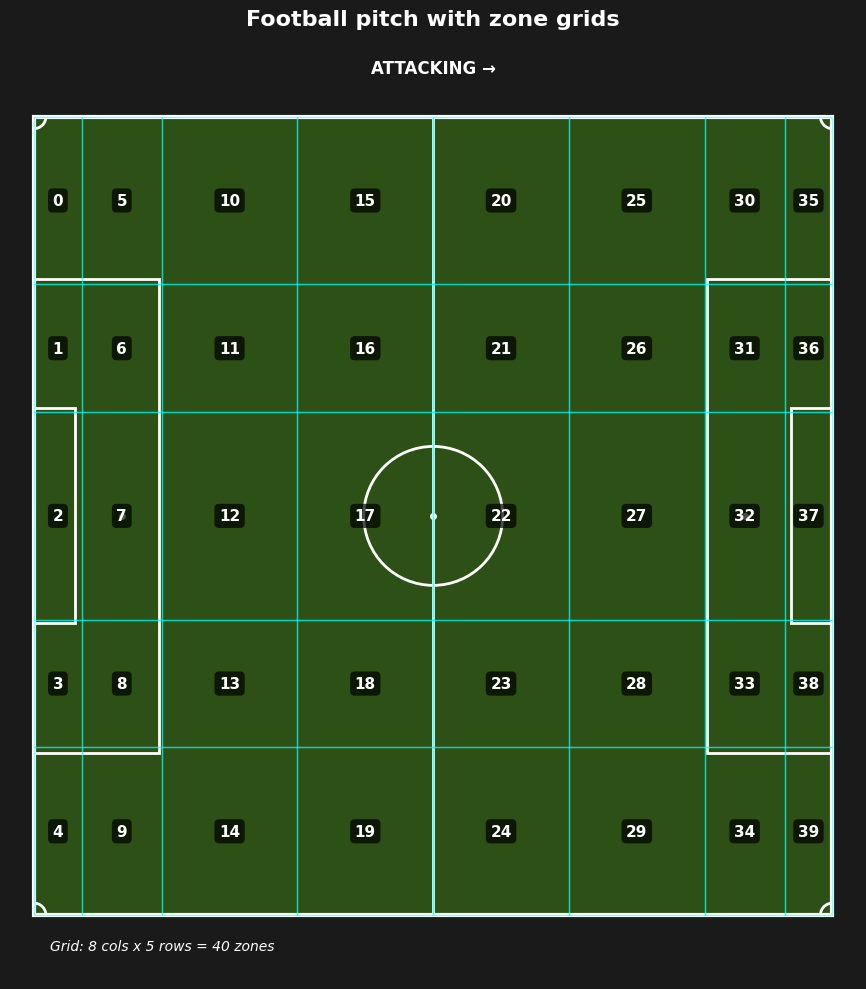

In [103]:
plot_pitch_zones(zt)
plt.show()

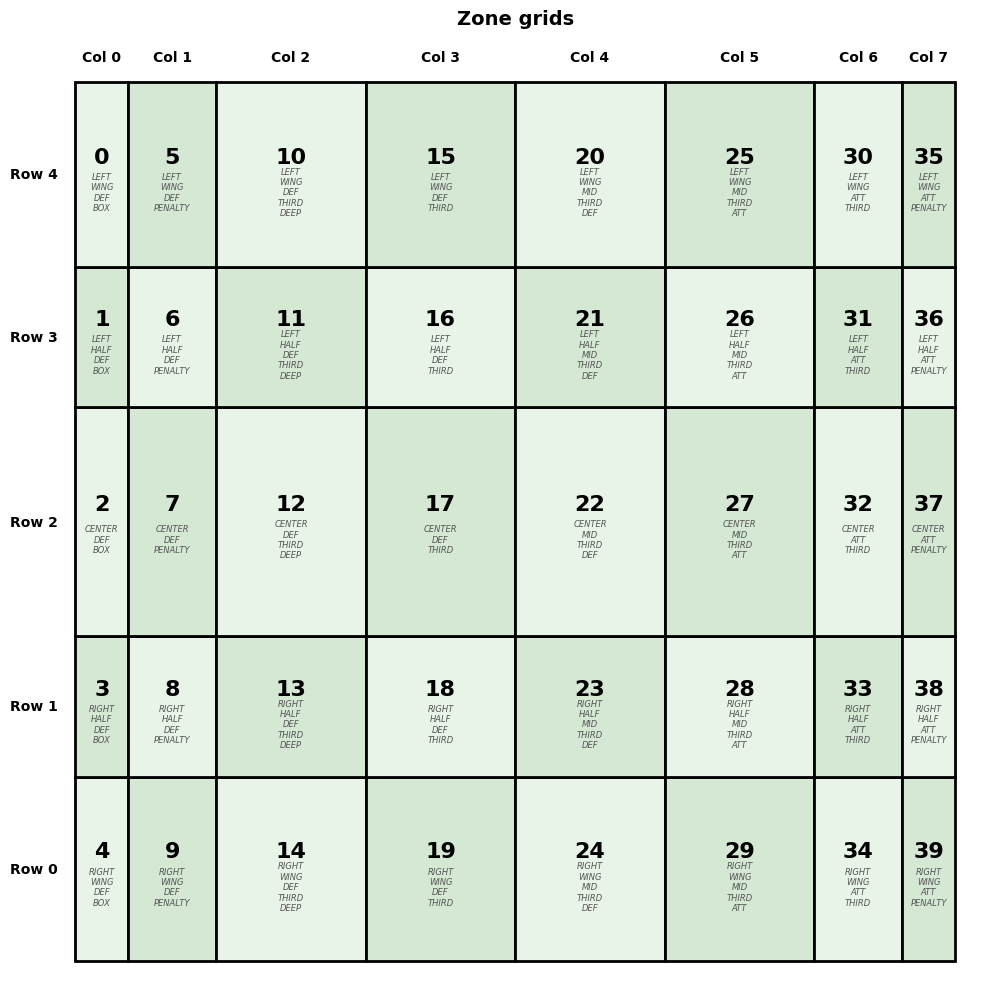

In [104]:
plot_zone_grid_simple(zt)
plt.show()

(<Figure size 1400x1000 with 2 Axes>,
 <Axes: title={'center': 'Zone activity'}>)

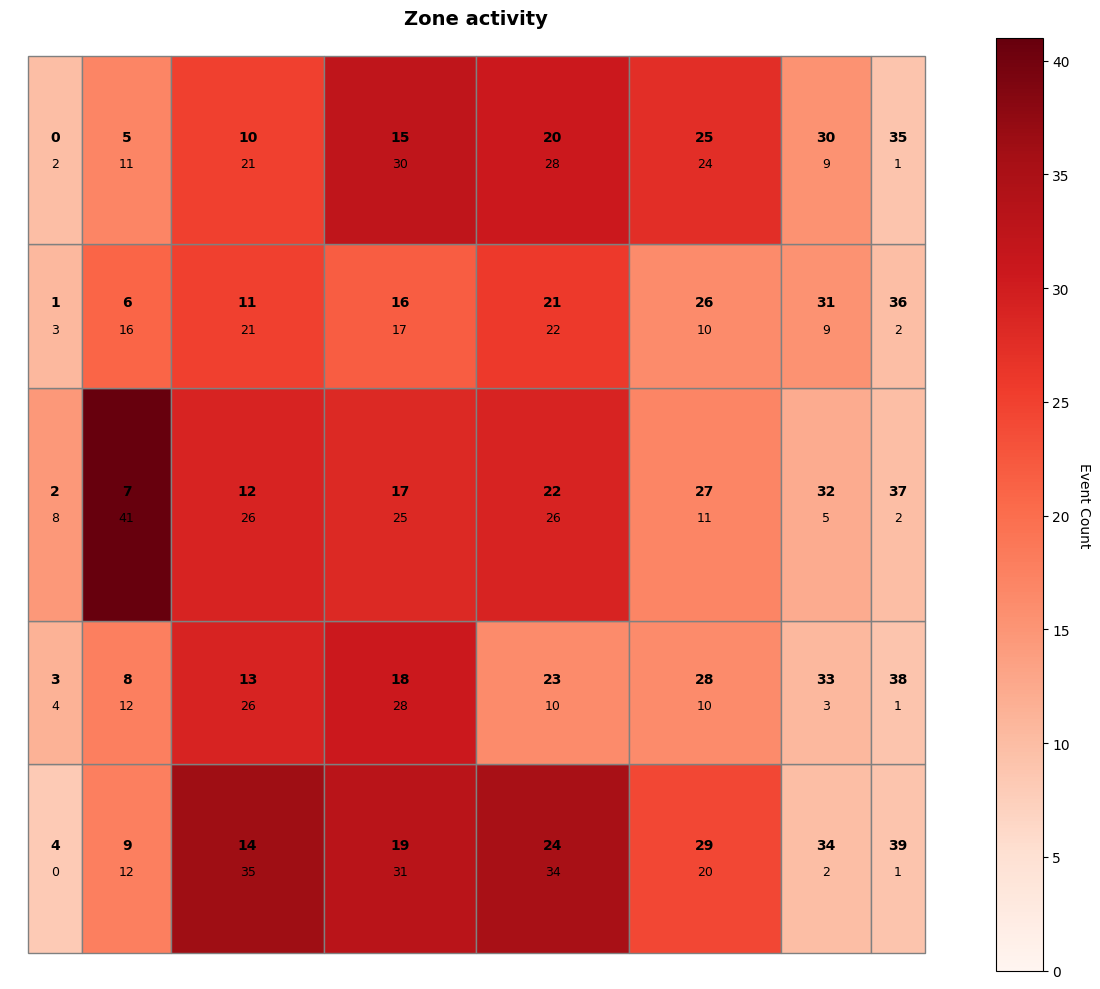

In [108]:
plot_zone_heatmap(zt, df_home["start_zone_id"].value_counts())

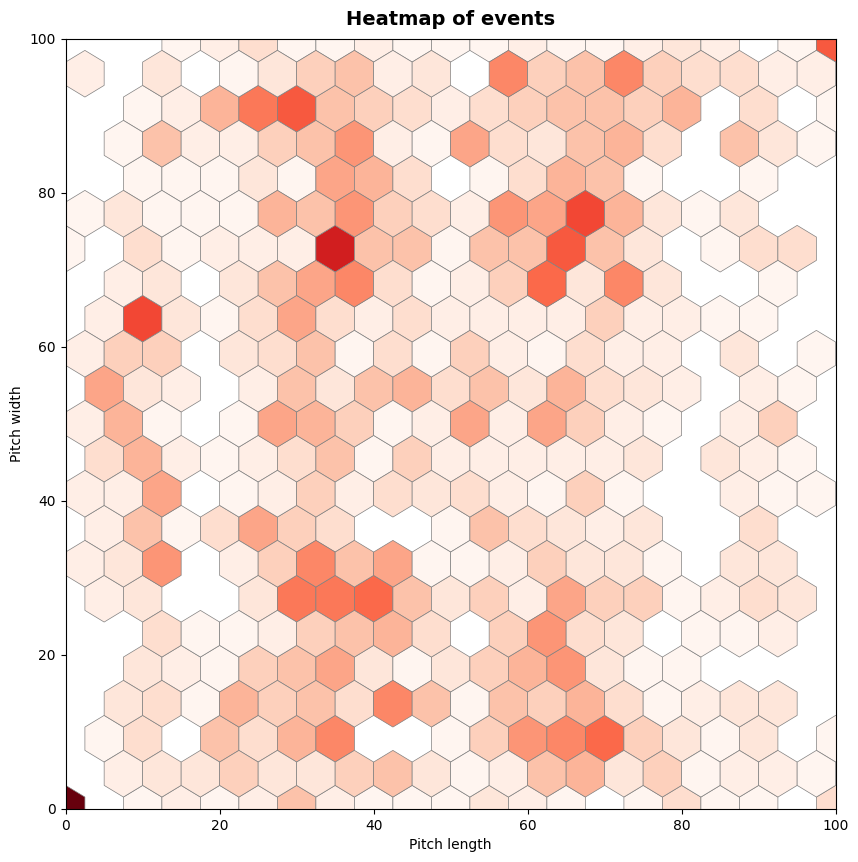

In [16]:
# heatmap of all events without zones
coordinates = df[["start_x", "start_y"]].dropna()

plt.figure(figsize=(14, 10))
plt.hexbin(
    coordinates["start_x"],
    coordinates["start_y"],
    gridsize=20,
    cmap="Reds",
    mincnt=1,
    edgecolors="gray",
    linewidths=0.5,
)
# plt.colorbar(label="Event count")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.gca().set_aspect("equal")
plt.title("Heatmap of events", fontsize=14, fontweight="bold", pad=10)
plt.xlabel("Pitch length")
plt.ylabel("Pitch width")
plt.grid(False)
plt.show()

## Graph

We create a graph with zones as nodes and the transitions as edges with the frequency as weight.

Node attributes: number of events, unique players.

Edge attributes: weight (frequency)

Potential: event types (pass, duel, etc.), player count, most common event (max frequency).

Do we use distributions? Do we use tags from events? 

The players are important for the transitions. How do we encode them? Distribution, counts?

Distribution of positions (GK, DEF, MID, ATT). Prune events for only PASSES, SHOTS, DUEL (TACKLES?)

In [117]:
def build_transition_graph(df):
    """
    Build a directed graph of zone transitions from event data

    Args:
        df: DataFrame with 'start_zone_id' and 'end_zone_id' columns
    Returns:
        DiGraph with zones as nodes and transitions as weighted edges
    """
    G = nx.DiGraph()
    transitions = df.dropna(subset=["start_zone_id", "end_zone_id"])
    for _, row in transitions.iterrows():
        start_zone = row["start_zone_id"]
        end_zone = row["end_zone_id"]
        if G.has_edge(start_zone, end_zone):
            G[start_zone][end_zone]["weight"] += 1
        else:
            G.add_edge(start_zone, end_zone, weight=1)

    # add node attributes
    for zone_id in G.nodes():
        zone_events = df[df["start_zone_id"] == zone_id]
        G.nodes[zone_id]["event_count"] = len(zone_events)
        G.nodes[zone_id]["unique_players"] = zone_events["player_id"].nunique()
        G.nodes[zone_id]["zone_name"] = zt.get_zone_name(zone_id)

    return G


def visualise_transition_graph(G):
    """
    Visualise the zone transition graph.

    Args:
        G: DiGraph with zones as nodes and transitions as weighted edges
    """

    pos = {zone_id: zt.get_zone_center(zone_id) for zone_id in G.nodes()}
    weights = [G[u][v]["weight"] for u, v in G.edges()]
    plt.figure(figsize=(7, 5))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=500,
        node_color="lightblue",
        arrowsize=20,
        edge_color=weights,
        edge_cmap=plt.cm.Blues,
        width=2,
    )
    sm = plt.cm.ScalarMappable(
        cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(weights), vmax=max(weights))
    )
    sm.set_array([])
    # cbar = plt.colorbar(sm, ax=plt.gca(), label="Transition frequency")
    plt.title("Zone transition graph", fontsize=14, fontweight="bold", pad=10)
    plt.show()

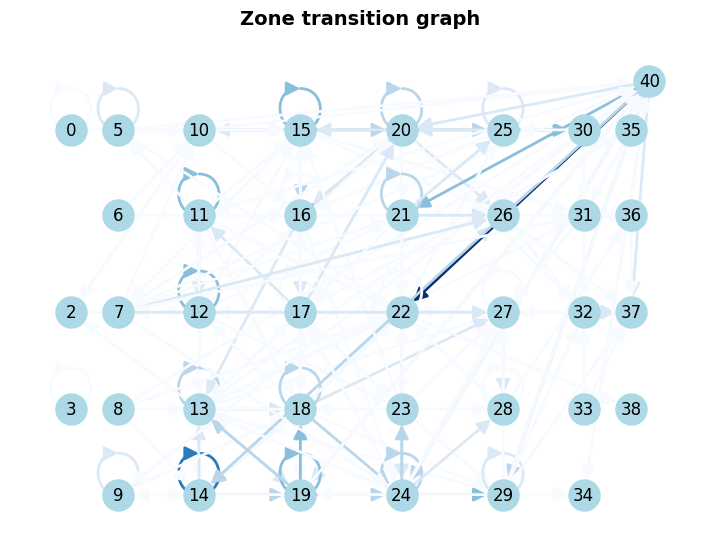

In [118]:
G_home = build_transition_graph(df_home)
visualise_transition_graph(G_home)

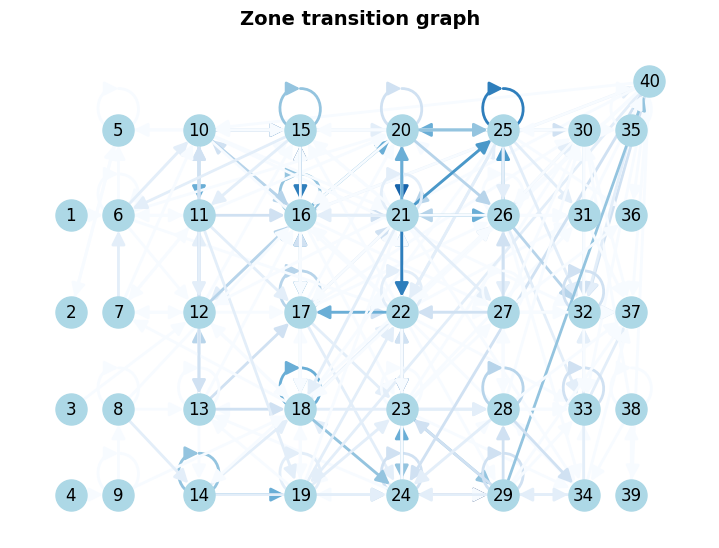

In [119]:
G_away = build_transition_graph(df_away)
visualise_transition_graph(G_away)